# CV2 - Lab 3: Tracking

## Environment Setup

### Imports

In [2]:
# Import modules
import cv2
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

### Useful Functions

In [3]:
def drawRectangle(frame, bbox, color = (255,0,0)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)

def drawText(frame, txt, location, color = (50,170,50)):
    cv2.putText(frame, txt, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

def show_init_bbox(video_input_file_name, init_bbox):
    video = cv2.VideoCapture(video_input_file_name)
    _, frame = video.read()
    drawRectangle(frame, init_bbox, color=(0, 255, 0))
    plt.imshow(frame)
    plt.axis('off')
    plt.show() 

### Check GOTURN pre-trained data

In [4]:
if (os.path.isfile('./goturn.prototxt') and os.path.isfile('./goturn.caffemodel')):
    print("Models are available")
else: 
    raise Exception("Models are not available")

Models are available


### Tracking code

In [5]:
def compute_tracking(video_input_file_name, init_bbox, methods= ["MIL", "MOSSE", "GOTURN"], save_frame_frequency=60, preview=False, output_name="output"): 
    bounding_boxes = {}
    for tracker_type in methods:
        # Select tracker
        print(f"Tracker : {tracker_type}")
        if tracker_type == 'BOOSTING':
            tracker = cv2.legacy_TrackerBoosting.create()
        elif tracker_type == 'MIL':
            tracker = cv2.legacy.TrackerMIL_create()
        elif tracker_type == 'KCF':
            tracker = cv2.legacy.TrackerKCF_create()
        elif tracker_type == 'CSRT':
            tracker = cv2.legacy_TrackerCSRT.create()
        elif tracker_type == 'TLD':
            tracker = cv2.legacy_TrackerTLD.create()
        elif tracker_type == 'MEDIANFLOW':
            tracker = cv2.legacy_TrackerMedianFlow.create()
        elif tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
        elif tracker_type == 'MOSSE':
            tracker = cv2.legacy_TrackerMOSSE.create()
        else:
            raise Exception("Tracker not available")

        # Read video
        video = cv2.VideoCapture(video_input_file_name)
        ok, frame = video.read()

        # Exit if video not opened
        if not video.isOpened():
            print("Could not open video")
            sys.exit()
        else : 
            width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
            
        video_output_file_name = output_name + '-' + tracker_type + '.mp4'
        video_out = cv2.VideoWriter(video_output_file_name,cv2.VideoWriter_fourcc(*'avc1'), 10, (width, height))

        if preview:
            # Create a window
            cv2.startWindowThread()
            cv2.namedWindow("preview")

        # Initialize tracker with first frame and bounding box
        bbox = init_bbox
        ok = tracker.init(frame, bbox)
        
        # Start tracker
        frame_count = 1 # 1 already read
        bboxes = []
        while True:
            ok, frame = video.read()
            if not ok:
                break 
            
            # Start timer
            timer = cv2.getTickCount()

            # Update tracker
            ok, bbox = tracker.update(frame)

            # Calculate Frames per second (FPS)
            fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

            # Draw bounding box
            if ok:
                drawRectangle(frame, bbox)
            else :
                drawText(frame, "Tracking failure detected", (80,140), (0, 0, 255))

            # Display Info
            drawText(frame, tracker_type + " Tracker", (80,60))
            drawText(frame, "FPS : " + str(int(fps)), (80,100))
            
            # Write frame to video
            video_out.write(frame)
            # Display result
            if preview:
                cv2.imshow('preview', frame)
                k = cv2.waitKey(30) & 0xff    #ESC  pressed
                if k == 27:
                    break

            # Save frame and update frame count
            if frame_count % save_frame_frequency == 0:
                print(f"  - Saving at frame {frame_count}")
                bboxes.append(bbox)
            frame_count += 1

        # Add the bounding box to the list
        bounding_boxes[tracker_type] = bboxes

        # Release video
        video.release()
        video_out.release()
        if preview:
            cv2.destroyAllWindows()

    return bounding_boxes


# Show bounding boxes returned by the tracker
def show_bboxes(video_input_file_name, bounding_boxes, save_frame_frequency):
    # Visualize trackers
    video = cv2.VideoCapture(video_input_file_name)
    _, _ = video.read()
    frame_count = 1

    # Visualize trackers
    colors = {k: [int(x) for x in (np.random.randint(0, high=255, size=(3,)))] for k in bounding_boxes.keys()}
    while True:
        ok, frame = video.read()
        if ok:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_count += 1
            if frame_count % save_frame_frequency == 0:
                # Figure with bboxes drawn
                for i, (tracker_type, bboxes) in enumerate(bounding_boxes.items()):
                    list_id = (frame_count // save_frame_frequency) - 1
                    # Draw the bounding box
                    color = colors[tracker_type]
                    if list_id < len(bboxes):
                        drawRectangle(frame, bboxes[list_id], color=color)
                    drawText(frame, tracker_type, (80 + (i*200),60), color=color)
                # Display the frame
                plt.imshow(frame)
                plt.axis('off')
                plt.show() 
        else: 
            break

## Exercise 1: Basic Tracker Comparison

The first exercise for week 3 consists of the comparison between at least 2 trackers of (BOOSTING, MIL,KCF, CRST, TLD, MEDIANFLOW, MOSSE) and the GOTURN tracker. In this case they will be compared:

- **MIL:**  Multiple Instance Learning (MIL) tracker, which is an improvement over the boosting tracker. It uses a set of positive and negative samples around the object to create a more robust classifier.
- **MOSSE:** Minimum Output Sum of Squared Error (MOSSE) tracker, which is a fast and robust single-object tracker based on adaptive correlation filters.
- **GOTURN:** Generic Object Tracking Using Regression Networks. GOTURN is a deep learning-based tracker that uses a convolutional neural network (CNN) to estimate the target’s location in the next frame. GOTURN is a fully convolutional network that takes as input the current frame and the bounding box of the target in the previous frame. The output of the network is the bounding box of the target in the current frame.

### Execution

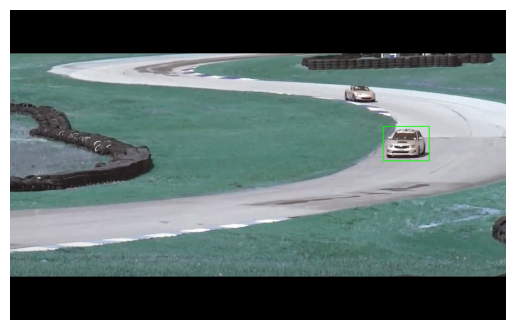

In [6]:
video_input_file_name = "./videos/race_car.mp4"
init_bbox = (1300, 405, 160, 120)
show_init_bbox(video_input_file_name, init_bbox)

Tracker : MIL
  - Saving at frame 60
  - Saving at frame 120
  - Saving at frame 180
Tracker : MOSSE
  - Saving at frame 60
  - Saving at frame 120
  - Saving at frame 180
Tracker : GOTURN
  - Saving at frame 60
  - Saving at frame 120
  - Saving at frame 180


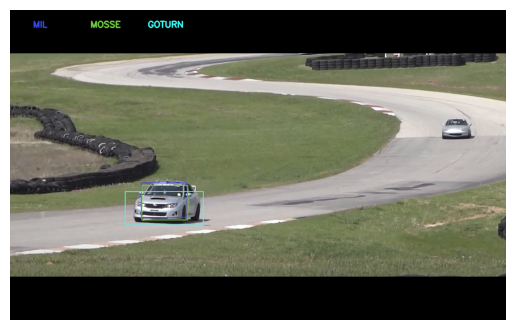

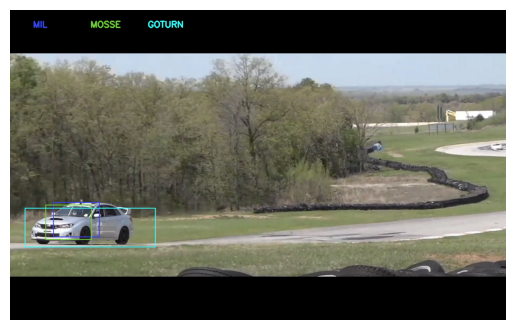

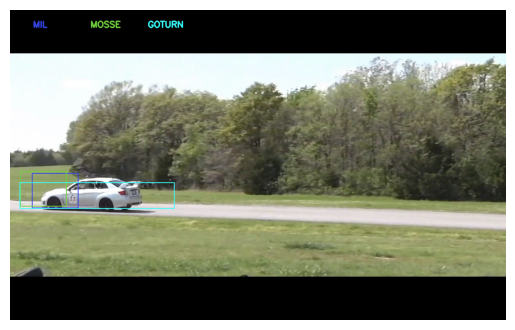

In [8]:
bboxes = compute_tracking(video_input_file_name, init_bbox, methods= ["MIL", "MOSSE", "GOTURN"], save_frame_frequency=60, preview=True, output_name="race_car")
show_bboxes(video_input_file_name, bboxes, save_frame_frequency=60)

### Analysis

Next the results obtained in the execution of the three trackers based on the results of arbitrary frames of the video will be analyzed briefly. The analysis will be carried out qualitatively, i.e., an approximation will be made of the precision, accuracy, speed and robustness of each of the trackers based on what is considered as ground-truth.

First of all, in terms of precision it should be noted that all trackers have an adequate behavior, following the car correctly during all the frames. Therefore, treating precision as the number of frames in which the bounding boxes are close enough to the actual bounding box, it can be said that all trackers have an accuracy of 100%.

However, in terms of accuracy, it can be said that the best performing tracker is GOTURN, as it is the only one that manages to adapt perfectly to the car when the perspective changes. While MIL and MOSSE only follow the nose of the car (MOSSE with a slightly worse accuracy), GOTURN adapts to the car in its entirety, adapting the dimensions of the bounding box to the new dimensions of the car. Therefore, in terms of accuracy, GOTURN is the best performer. This last aspect makes GOTURN the most robust tracker, as it is the only one that adapts to a substantial change such as the car's perspective. It should be noted that the robustness between MIL and MOSSE is very similar in this case, but in later runs, it will be seen that MIL has a more stable and robust behavior than MOSSE (and even than GOTURN).

In relation to performance, MOSSE is undoubtedly the faster tracker. It manages to maintain frame-rates of 300 fps with the executed hardware. On the other hand, MIL and GOTURN have a very similar performance, with frame-rates of approximately 10 fps on average, with performance peaks of up to 20 fps at most. Therefore, in terms of performance, MOSSE is the best performer, additionally, for this case, in terms of trade-off between accuracy and computational speed, MIL is undoubtedly the worst.

Finally, dealing superficially and qualitatively with other quantitative metrics beyond accuracy. The following can be stated:
- **Intersection over Union (IoU)**: GOTURN is the best as it is able to adapt to the perspective of the car, increasing the intersection area.
- **Center Location Error (CLE)**: The best tracker is GOTURN, since it is the only one that does not focus on the nose of the car, but focuses on the car as a whole.
- **Success Rate (SR)**: As with IoU, GOTURN is the best performer, as it is the only one that manages to follow the car in its entirety, increasing the surface in intersection.

## Exercise 2: Tracker Performance with Lighting Variations and Occlusions

The next exercise will be identical to the previous one (also with the same trackers), with the difference that non-trivial videos will be used, i.e. two videos will be used, one containing lighting changes and the other with occlusions. 

In [6]:
# votchallenge images to video
def create_video_from_images(image_dir, video_name, fps=24):
    image_files = os.listdir(image_dir)
    image_files.sort()
    image_files = [os.path.join(image_dir, f) for f in image_files]
    frame = cv2.imread(image_files[0])
    height, width, _ = frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    video = cv2.VideoWriter(video_name, fourcc, fps, (width,height))
    for image in image_files:
        video.write(cv2.imread(image))
    cv2.destroyAllWindows()
    video.release()

### Video 1: Lighting Variations

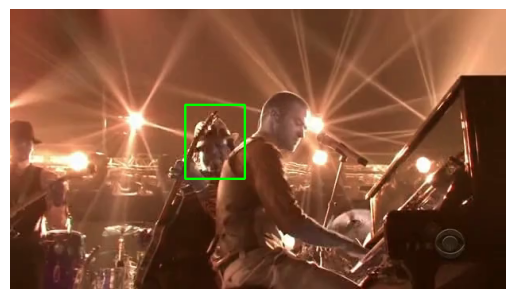

In [24]:
video_input_file_name = "./videos/festa.mp4"
init_bbox = (220, 120, 75, 93)
show_init_bbox(video_input_file_name, init_bbox)


Tracker : MIL
  - Saving at frame 120
  - Saving at frame 240
  - Saving at frame 360
Tracker : MOSSE
  - Saving at frame 120
  - Saving at frame 240
  - Saving at frame 360
Tracker : GOTURN
  - Saving at frame 120
  - Saving at frame 240
  - Saving at frame 360


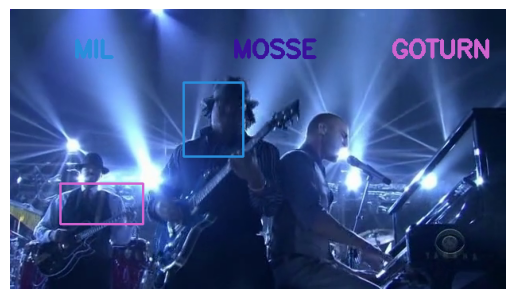

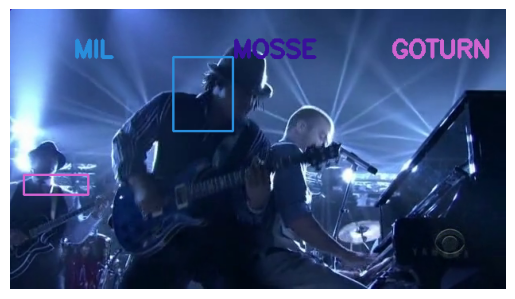

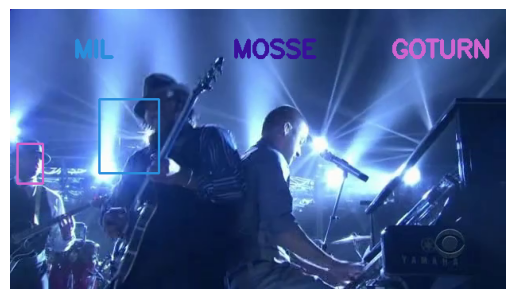

In [29]:
bboxes = compute_tracking(video_input_file_name, init_bbox, methods= ["MIL", "MOSSE", "GOTURN"], save_frame_frequency=120, preview=True, output_name="race_car")
show_bboxes(video_input_file_name, bboxes, save_frame_frequency=120)

#### Analysis

In this case the only tracker that manages to keep the guitarist's face is MIL. Although in some frames there may be some small variation with respect to the face itself that may affect the precision, MIL is the only one that manages to follow the face of the guitarist in its entirety. Therefore, in terms of accuracy, MIL is the best performer with almost perfect precision. Of course, due to small deviations its accuracy is affected and therefore mentioned metrics (IoU, CLE, SR) are not as good as in the previous case (the car).

GOTURN presents a very bad robustness to liminosity changes and such a dark and chaotic environment, centering the bounding box in the center of the screen, to end up tracking the wrong musician. It should be noted that MOSSE did not work in any frame.

Given this situation, it makes no sense to analyze the computational performance of the trackers, since all of them have failed except for one (but note that the computational performance are the same as in the previous exercise).

### Video 2: Occlusions

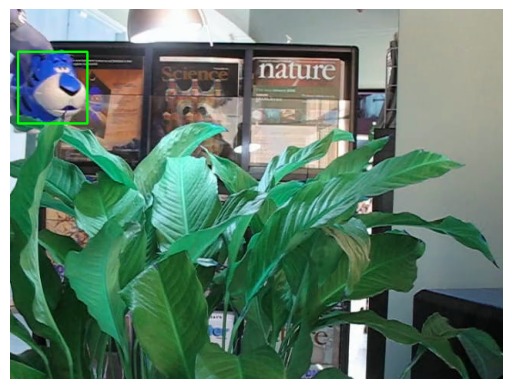

In [9]:
video_input_file_name = "./videos/miau.mp4"
init_bbox = (10, 55, 90, 93)
show_init_bbox(video_input_file_name, init_bbox)

Tracker : MIL
  - Saving at frame 120
  - Saving at frame 240
  - Saving at frame 360
Tracker : MOSSE
  - Saving at frame 120
  - Saving at frame 240
  - Saving at frame 360
Tracker : GOTURN
  - Saving at frame 120
  - Saving at frame 240
  - Saving at frame 360


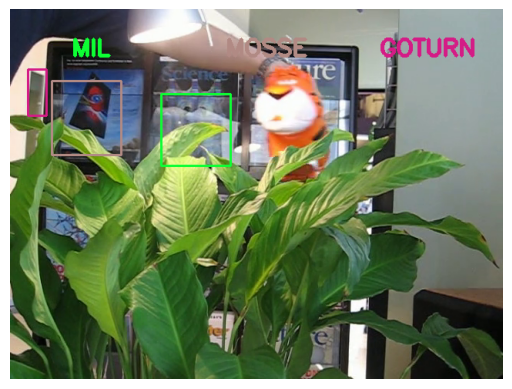

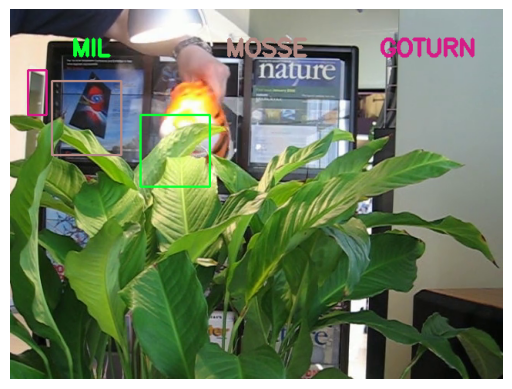

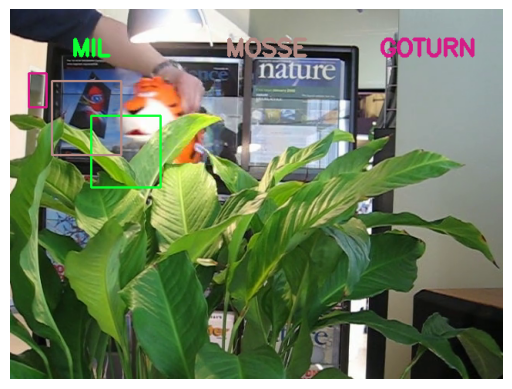

In [14]:
bboxes = compute_tracking(video_input_file_name, init_bbox, methods= ["MIL", "MOSSE", "GOTURN"], save_frame_frequency=120, preview=True, output_name="race_car")
show_bboxes(video_input_file_name, bboxes, save_frame_frequency=120)

#### Analysis

As in the previous case, MIL is the only one that manages to follow the object. Although the accuracy is not perfect because it has frames in which the tiger loses, it is the only one that manages to have a moderately adequate behavior. Thus, the comments to be made are the same as in the previous case.

## CSRT Tracker

Since for the last video, MOSSE and GOTURN are completely useless and the performance of MIL could be better, we wanted to try a new tracker called CSRT, which is a correlation-based tracker that uses an adaptive correlation filter to track objects in videos. 

This tracker has shown perfect behavior for this latest video, proving robust to occlusions by maintaining perfect accuracy and precision in tracking the tiger. Additionally in terms of performance, CSRT is computed with a frame-rate of 30 fps, which is quite good compared to MIL and GOTURN.

For the rest of the videos, CSRT has not demonstrated to be better than MIL, so it has been decided not to include it in the analysis of the trackers. Identical performance for the car video and terrible performance for the lighting video can be seen below.

Tracker : CSRT
  - Saving at frame 60
  - Saving at frame 120
  - Saving at frame 180


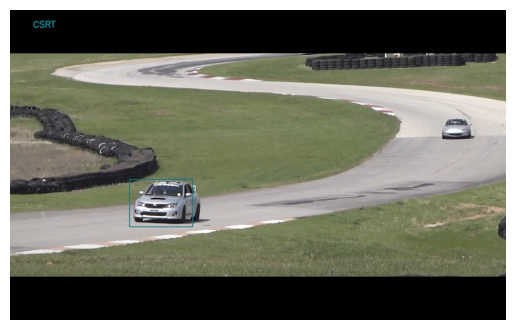

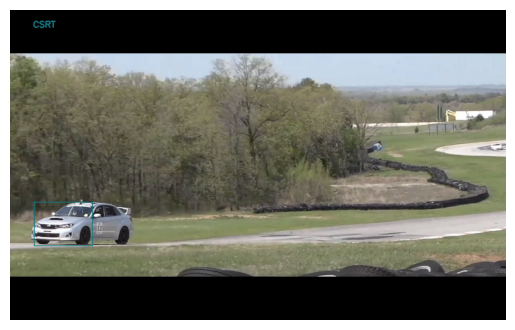

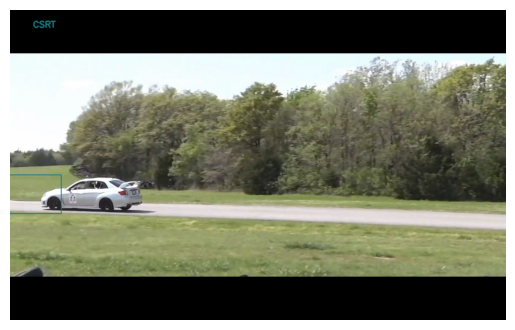

Tracker : CSRT
  - Saving at frame 120
  - Saving at frame 240
  - Saving at frame 360


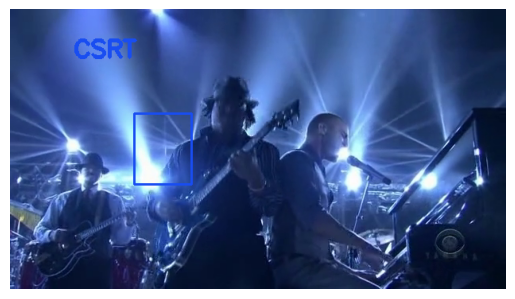

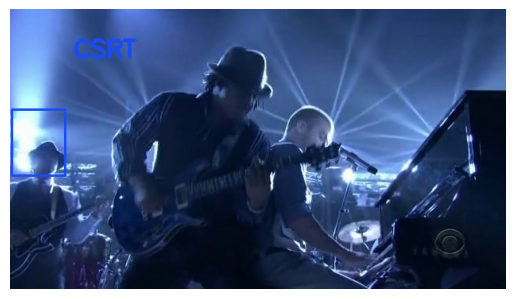

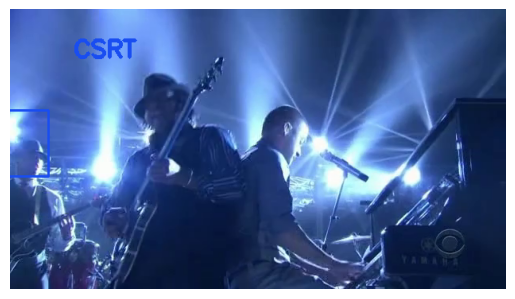

Tracker : CSRT
  - Saving at frame 120
  - Saving at frame 240
  - Saving at frame 360


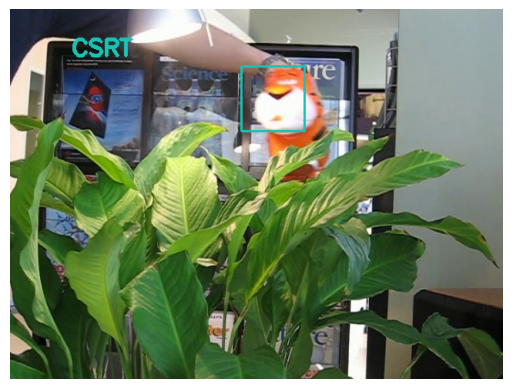

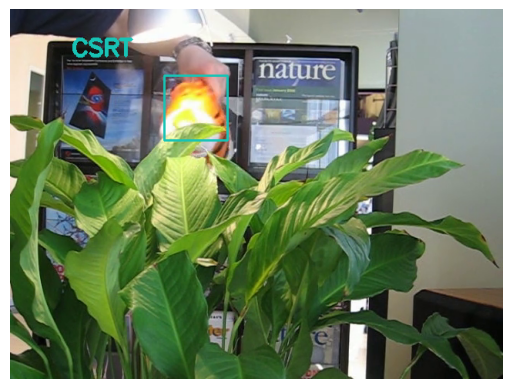

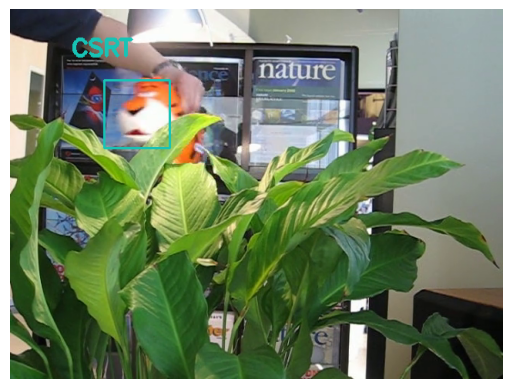

In [13]:
video_input_file_name = "./videos/race_car.mp4"
init_bbox = (1300, 405, 160, 120)
bboxes = compute_tracking(video_input_file_name, init_bbox, methods= ["CSRT"], save_frame_frequency=60, preview=True, output_name="race_car")
show_bboxes(video_input_file_name, bboxes, save_frame_frequency=60)

video_input_file_name = "./videos/festa.mp4"
init_bbox = (220, 120, 75, 93)
bboxes = compute_tracking(video_input_file_name, init_bbox, methods= ["CSRT"], save_frame_frequency=120, preview=True, output_name="race_car")
show_bboxes(video_input_file_name, bboxes, save_frame_frequency=120)

video_input_file_name = "./videos/miau.mp4"
init_bbox = (10, 55, 90, 93)
bboxes = compute_tracking(video_input_file_name, init_bbox, methods= ["CSRT"], save_frame_frequency=120, preview=True, output_name="race_car")
show_bboxes(video_input_file_name, bboxes, save_frame_frequency=120)

## Global Analysis

Therefore, in general terms, it can be said that MIL is the best performing tracker in almost all cases, being the most robust to the cases presented and the best performing in terms of precision and accuracy (with the exception of the perfect performance of GOTURN in the first video). 

As a final conclusion, it can be stated that, contrary to what could be initially expected, GORTURN is not the most robust tracker, probably because its resizing is another problem to be taken into account, being really difficult to maintain this robustness in environments with a slight difference between the object to track and the background (video of the illumination) or with the appearance of occluding elements. Thus, the robustness of GOTURN will be more applied to changes in the object to be tracked, rather than to changes in the environment.